In [423]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [124]:
hr = pd.read_csv('C:/Users/rbarr/Desktop/Ironhack/repos/human-resources-data-set/HRDataset_v13.csv', na_values = 
                 ['N/A - still employed', 'N/A - Has not started yet'])
hr.columns = hr.columns.str.lower()
hr.columns

hr.drop(columns = ['employee_name', 'marriedid', 'maritalstatusid', 'empstatusid', 'deptid', 'fromdiversityjobfairid', 
                   'positionid', 'sex', 'managername', 'performancescore', 'lastperformancereview_date', 'dayslatelast30'] 
                   , inplace = True)
hr.columns = ['id', 'gender', 'performance', 'pay', 'terminated', 'position', 'state', 'zip', 'dob', 'marital', 'citizen', 
              'hispanic', 'race', 'hire_date', 'terminate_date', 'terminate_reason', 'status', 'department', 'manager_id', 
              'source', 'engagement', 'satisfaction', 'projects']

hr = hr[hr.isnull().all(axis = 1) == False]

hr.loc[hr['gender'] == 1, 'gender'] = 0
hr.loc[hr['gender'] == 0, 'gender'] = 1
hr.loc[(~hr['terminate_date'].isna()) & (hr['terminate_reason'].isna()), 'terminate_reason'] = 'none recorded'
hr.loc[hr['manager_id'].isna(), 'manager_id'] = -1
hr['hispanic'] = hr['hispanic'].str.lower().str.replace('no', '0').str.replace('yes', '1')

floats = ['pay', 'engagement']
ints = ['id', 'gender', 'performance', 'terminated', 'zip', 'hispanic', 'manager_id', 'satisfaction', 'projects']
objects = ['position', 'state', 'marital', 'citizen', 'race', 'terminate_reason', 'status', 'department', 'manager_id', 
           'source']
datetimes = ['dob', 'hire_date', 'terminate_date']

hr[floats] = hr[floats].astype('float64')
hr[ints] = hr[ints].astype('int64')
hr[objects] = hr[objects].astype('str').apply(lambda x: x.str.lower().str.strip())
hr[datetimes] = hr[datetimes].apply(pd.to_datetime)
hr.dtypes

id                           int64
gender                       int64
performance                  int64
pay                        float64
terminated                   int64
position                    object
state                       object
zip                          int64
dob                 datetime64[ns]
marital                     object
citizen                     object
hispanic                     int64
race                        object
hire_date           datetime64[ns]
terminate_date      datetime64[ns]
terminate_reason            object
status                      object
department                  object
manager_id                  object
source                      object
engagement                 float64
satisfaction                 int64
projects                     int64
dtype: object

In [188]:
zips = pd.read_csv('C:/Users/rbarr/Desktop/Ironhack/repos/us-zip-code-latitude-and-longitude.csv', sep = ';')
zips.columns = zips.columns.str.lower()
zips = zips[['zip', 'latitude', 'longitude']]
zips.head()

,zip,latitude,longitude
0,71937,34.398483,-94.39398
1,72044,35.624351,-92.16056
2,56171,43.660847,-94.74357
3,49430,43.010337,-85.89754
4,52585,41.194129,-91.98027


In [126]:
hr = hr.merge(zips, on = 'zip')

In [127]:
hr.loc[hr['position'].str.contains('(?:sr\.|senior)'), 'position'] = 'senior'
hr.loc[hr['position'].str.contains('manager'), 'position'] = 'manager'
hr.loc[hr['position'].str.contains('director'), 'position'] = 'director'
hr.loc[hr['position'].str.contains('c[a-z]o$'), 'position'] = 'chief'
hr.loc[~hr['position'].str.contains('(?:sr\.|senior|manager|director|c[a-z]o$)'), 'position'] = 'junior'

hr.loc[hr['state'] == 'ma', 'state'] = 0
hr.loc[hr['state'] != 'ma', 'state'] = 1

hr.loc[hr['manager_id'].isin(hr['manager_id'].value_counts().index[-5:]), 'manager_id'] = '0'

hr.loc[hr['source'].isin(hr['source'].value_counts().index[-7:]), 'source'] = 'other'

def age(dob):
    if dob.month <= pd.Timestamp.now().month & dob.day <= pd.Timestamp.now().day:
        return pd.Timestamp.now().year - dob.year
    else:
        return pd.Timestamp.now().year - dob.year + 1

hr['age'] = hr['dob'].apply(age)
hr.loc[hr['terminate_date'].isna(), 'tenure'] = pd.Timestamp.now() - hr['hire_date']
hr.loc[~hr['terminate_date'].isna(), 'tenure'] = hr['terminate_date'] - hr['hire_date']
hr['tenure'] = hr['tenure'].apply(lambda x: x.days)
hr['hire_date'] = hr['hire_date'].apply(lambda x: x.toordinal())

hr.drop(columns = ['id', 'zip', 'dob', 'terminate_date', 'status'], inplace = True)

In [128]:
hr.columns

Index(['gender', 'performance', 'pay', 'terminated', 'position', 'state',
       'marital', 'citizen', 'hispanic', 'race', 'hire_date',
       'terminate_reason', 'department', 'manager_id', 'source', 'engagement',
       'satisfaction', 'projects', 'latitude', 'longitude', 'age', 'tenure'],
      dtype='object')

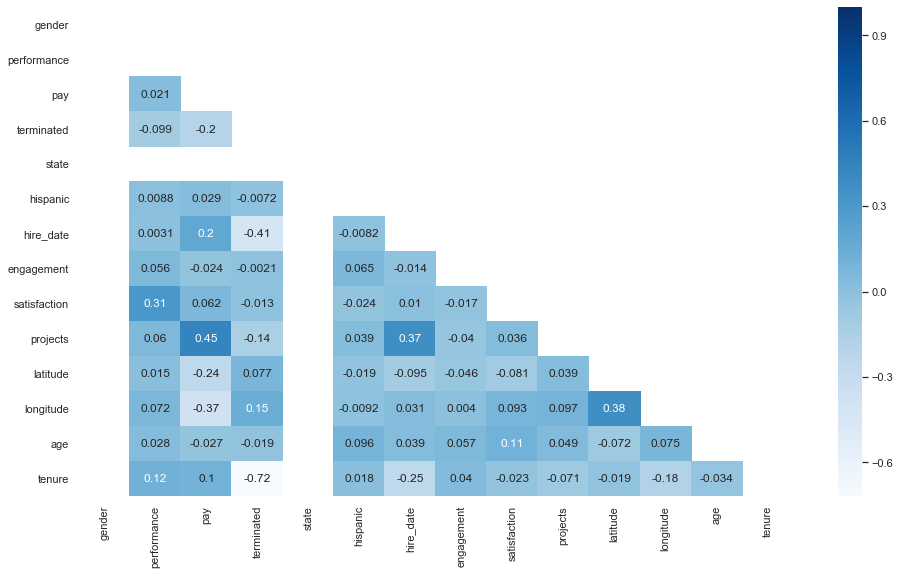

In [452]:
plt.figure(figsize = (16, 9))
sns.set_context('notebook')
sns.set_style('whitegrid')
mask = np.zeros_like(hr.corr())
mask[np.triu_indices_from(mask)] = True # removes upper triangle

sns.heatmap(hr.corr(), mask = mask, cmap = 'Blues', annot = True)

In [436]:
X = pd.get_dummies(hr.iloc[:, ~hr.columns.isin(['terminated', 'terminate_reason'])])
y = hr['terminated']

accuracy = []

for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8)
    model_fit = LogisticRegression(solver = 'lbfgs', max_iter = 1000).fit(X_train, y_train)
    y_pred = model_fit.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    
sum(accuracy) / len(accuracy)

0.872903225806452

In [437]:
confusion_matrix(y_test, y_pred)

array([[39,  2],
       [ 3, 18]], dtype=int64)

In [438]:
accuracy = []

for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8)
    X_train = RobustScaler().fit(X).transform(X_train)
    X_test = RobustScaler().fit(X).transform(X_test)
    model_fit = LogisticRegression(solver = 'lbfgs', max_iter = 1000).fit(X_train, y_train)
    y_pred = model_fit.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    
sum(accuracy) / len(accuracy)

0.9974193548387098

In [439]:
confusion_matrix(y_test, y_pred)

array([[41,  0],
       [ 0, 21]], dtype=int64)

In [440]:
accuracy = []

for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8)
    X_train = RobustScaler().fit(X).transform(X_train)
    X_test = RobustScaler().fit(X).transform(X_test)
    model_fit = SVC(gamma = 'auto').fit(X_train, y_train)
    model_fit.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))

sum(accuracy) / len(accuracy)

0.555483870967742

In [441]:
confusion_matrix(y_test, y_pred)

array([[29, 16],
       [12,  5]], dtype=int64)